<a href="https://colab.research.google.com/github/arifinnasif/Natural-Hazard-Prediction/blob/master/lightnet_on_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import tqdm

In [2]:
from google.colab import drive
import os

drive.mount("/content/drive", force_remount=True)
os.chdir(os.path.join("/content", "drive", "MyDrive", "Datasets", "GLM"))

Mounted at /content/drive


## ConvLSTM

In [3]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        # print("size of h_cur", h_cur.size())
        # print("size of combined", combined.size())

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [4]:
# conv_lstm = ConvLSTM(1,[8],[(5,5)],1, batch_first=True) # 1 channel, 8 hidden channel (from geng), 5x5 kernel, 1 layer(?), batch first -> batch er size input tensor e first e dicci,
# x = torch.rand((32, 6, 1, 25, 25)) # 32 samples in a batch (batch first), prev 6 hours, 1 channel, 25x25 grid
# # convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
# _, last_states = conv_lstm(x)
# h,c = last_states[0]  # 0 for layer index, 0 for h index
# print(last_states[0][1].size())
# print("-----")
# print(h.size())


In [5]:
# x_ = torch.rand((32, 6, 50, 50))
# conv_ = nn.Conv2d(in_channels = 6, out_channels = 6*4, kernel_size = 5, groups = 6, stride = 2, padding = 2)
# # conv_.weight.data = [None, None, ...].repeat(64, 1, 1, 1)
# # print(conv_.weight.data.size())
# conv_(x_).size()

In [6]:
class Encoder_old(nn.Module):
  def __init__(self):
    super(Encoder_old, self).__init__()
    self.prev_hours = 6
    self.conv_2 = nn.Conv2d(in_channels = self.prev_hours,
                          out_channels = self.prev_hours*4, # each input frame gets mapped to 4 layer
                          groups = self.prev_hours,
                          kernel_size = 7,
                          stride = 2,
                          padding = 3)
    self.conv_lstm = ConvLSTM(input_dim = 4,
                               hidden_dim = [8],
                               kernel_size = [(5,5)],
                               num_layers = 1,
                               batch_first=True)
    # print(self.conv_2.weight.data.size())

  def forward(self, input_tensor):
    x = self.conv_2(input_tensor.flatten(1,2))
    _, last_states = self.conv_lstm(torch.unflatten(x, dim = 1, sizes = (6, 4)))
    h,c = last_states[0]

    return h,c





In [7]:
class Encoder(nn.Module):
  def __init__(self, in_channels_for_a_given_time, prev_hours):
    super(Encoder, self).__init__()
    self.prev_hours = prev_hours
    self.hidden_dim = 8
    self.stride = 2
    self.in_channels_for_a_given_time = in_channels_for_a_given_time
    self.conv_2 = nn.Conv2d(in_channels = self.in_channels_for_a_given_time, # one 2d lightnig grid at time t
                          out_channels = 4, # from geng
                          kernel_size = 7,
                          stride = self.stride,
                          padding = 3)
    self.conv_lstm_cell = ConvLSTMCell(input_dim = 4,
                               hidden_dim = self.hidden_dim,
                               kernel_size = (5,5),
                               bias=True)
    # print(self.conv_2.weight.data.size())

  def forward(self, input_tensor):
    # x = self.conv_2(input_tensor.flatten(1,2))
    # _, last_states = self.conv_lstm(torch.unflatten(x, dim = 1, sizes = (6, 4)))
    # h,c = last_states[0]
    b, prev_hours, channels, height, width = input_tensor.size()
    h,c = self.init_hidden(batch_size=b, image_size=(height // self.stride, width // self.stride))

    for t in range(prev_hours):
      x = self.conv_2(input_tensor[:, t, :, :, :])
      h, c = self.conv_lstm_cell(x, cur_state=[h, c])
      return h,c

    #####

    #     layer_output_list = []
    #     last_state_list = []

    #     seq_len = input_tensor.size(1)
    #     cur_layer_input = input_tensor

    #     for layer_idx in range(self.num_layers):

    #         h, c = hidden_state[layer_idx]
    #         output_inner = []
    #         for t in range(seq_len):
    #             h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
    #                                              cur_state=[h, c])
    #             output_inner.append(h)

    #         layer_output = torch.stack(output_inner, dim=1)
    #         cur_layer_input = layer_output

    #         layer_output_list.append(layer_output)
    #         last_state_list.append([h, c])

    #     if not self.return_all_layers:
    #         layer_output_list = layer_output_list[-1:]
    #         last_state_list = last_state_list[-1:]

    #     return layer_output_list, last_state_list

    # return h,c

  def init_hidden(self, batch_size, image_size):
      height, width = image_size
      return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv_2.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv_2.weight.device))





In [8]:
class Fusion(nn.Module):
  def __init__(self, total_in_channels):
    super(Fusion,self).__init__()
    # h_stacked = torch.cat(h_list, dim = 1)
    # sc_stacked = torch.cat(c_list, dim = 1)
    self.conv_3 = nn.Conv2d(in_channels = total_in_channels,
                            out_channels = 64, # from the paper
                            kernel_size=1)
    self.conv_4 = nn.Conv2d(in_channels = total_in_channels,
                            out_channels = 64, # from the paper
                            kernel_size=1)

  def forward(self, h_list, c_list):
    h_stacked = torch.cat(h_list, dim = 1)
    c_stacked = torch.cat(c_list, dim = 1)


    h_fused_conved = self.conv_3(h_stacked)
    c_fused_conved = self.conv_4(c_stacked)

    return h_fused_conved, c_fused_conved


In [9]:
class Decoder(nn.Module):
  def __init__(self, in_channels_for_a_given_time, next_hours):
    super(Decoder, self).__init__()
    self.next_hours = next_hours
    self.in_channels_for_a_given_time = in_channels_for_a_given_time
    self.conv_5 = nn.Conv2d(in_channels = self.in_channels_for_a_given_time, # single L_{-1} frame
                          out_channels = 4, # from geng
                          kernel_size = 7,
                          stride = 2,
                          padding = 3)
    self.conv_lstm_cell = ConvLSTMCell(input_dim=4, # output of conv
                                       hidden_dim=64, # from geng
                                       kernel_size=(5,5), # from geng
                                       bias=True)
    # print(self.conv_2.weight.data.size())
    self.deconv = nn.ConvTranspose2d(in_channels=64, # as previous conv_lstm_cell had 64 hidden dim so the size is [:,64,:,:]
                                     out_channels=64, # from geng
                                     kernel_size = 7, # from geng
                                     stride = 2, # from geng
                                     padding = 3,
                                     output_padding = 1) # not sure

    self.conv_6 = nn.Conv2d(in_channels = 64, # previous deconv
                          out_channels = 1, # as it is just one layer
                          kernel_size = 1, # from geng
                          stride = 1) # from geng

  def forward(self, input_tensor_L_neg_1, h, c):
    # x = self.conv_2(input_tensor.flatten(1,2))
    # _, last_states = self.conv_lstm(torch.unflatten(x, dim = 1, sizes = (6, 4)))
    # h,c = last_states[0]
    b, _, height, width = input_tensor_L_neg_1.size()

    pred_output = []

    for i in range(self.next_hours):
      # print("---")
      x = self.conv_5(input_tensor_L_neg_1)
      # print(x.size())
      # print("dbg", x.size())
      h, c = self.conv_lstm_cell(x, cur_state=[h, c])
      # print(h.size())
      x = self.deconv(h)
      # print(x.size())
      x = self.conv_6(x)
      # print(x.size())

      pred_output.append(x)
      # print("---")

    pred_output = torch.stack(pred_output, 0).permute(1, 0, 2, 3, 4)
    # print(torch.stack(pred_output, 0).size())





    return pred_output



In [10]:
class LightNet(nn.Module):
  def __init__(self):
    super(LightNet, self).__init__()
    self.obs_enc = Encoder(in_channels_for_a_given_time=1,
                           prev_hours=6)
    self.fus = Fusion(8) # total h (or c) channels. as we are going to use just one h from the obs encoder (size of h = [:,8,:,:])
    self.pred_dec = Decoder(in_channels_for_a_given_time=1,
                            next_hours=6)

  def forward(self, input_tensor):
    h,c = self.obs_enc(input_tensor)
    h,c = self.fus([h],[c])
    out = self.pred_dec(input_tensor[:,-1,:,:,:], h, c)

    return out

In [11]:
# model = LightNet()
# x = torch.rand((32, 6, 1, 50, 50)) # [batch_size, prev_hours, input_layer, image_height, image_width]
# model(x)

In [12]:
def MeteorologicalMeasures(output, target):
  output, target = output.to(torch.device("cuda")), target.to(torch.device("cuda"))
  true_pos = 0
  true_neg = 0

  false_pos = 0
  false_neg = 0

  ytrue = target
  ypred = torch.sigmoid(output)
  ypred = torch.round(ypred)
  true_positives = torch.sum(ytrue * ypred)
  false_positives = torch.sum((1-ytrue)*ypred)
  possible_positives = torch.sum(ytrue)
  POD = true_positives / (possible_positives + 1e-10)
  predicted_positives = torch.sum(ypred)
  FAR = false_positives / (predicted_positives + 1e-10)
  return POD, FAR



In [13]:
def weighted_cross_entropy_with_logits(logits, targets, pos_weight):
    return torch.sum(targets * -torch.sigmoid(logits).log() * pos_weight + (1 - targets) * -(1 - torch.sigmoid(logits)).log())/logits.size(0)

data has the size :  torch.Size([1000, 1, 50, 50])
Epoch [ 1 / 50 ] 

100%|██████████| 26/26 [01:24<00:00,  3.23s/it]


train
loss 10394.715232613533 | acc 0.646673076923077 | POD 0.0 | FAR 0.0
validation
loss 7961.205991164157 | acc 0.0059328125 | POD 0.0 | FAR 0.0

Epoch [ 2 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 7945.970868123447 | acc 0.011272355769230769 | POD 0.0 | FAR 0.0
validation
loss 7274.650181294588 | acc 0.0040104166666666665 | POD 0.0 | FAR 0.0

Epoch [ 3 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 7679.579556465172 | acc 0.004183333333333333 | POD 0.0 | FAR 0.0
validation
loss 7138.832382979257 | acc 0.0029026041666666666 | POD 0.0 | FAR 0.0

Epoch [ 4 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 7550.799570140477 | acc 0.002795272435897436 | POD 0.0 | FAR 0.0
validation
loss 7010.029652571119 | acc 0.0024234375 | POD 0.0 | FAR 0.0

Epoch [ 5 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 7370.976042395123 | acc 0.0027116185897435897 | POD 0.0 | FAR 0.0
validation
loss 6758.664258085023 | acc 0.002715625 | POD 0.0 | FAR 0.0

Epoch [ 6 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 6851.636497910854 | acc 0.006995592948717949 | POD 0.0062266964038723005 | FAR 0.48012271909173043
validation
loss 5797.900637332683 | acc 0.018910416666666666 | POD 0.06407217398593883 | FAR 0.8656043207781658

Epoch [ 7 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 5647.873728145457 | acc 0.037106570512820514 | POD 0.25373397154334865 | FAR 0.8994558520579751
validation
loss 4908.648630438769 | acc 0.04244427083333333 | POD 0.370887715111712 | FAR 0.9123564875538188

Epoch [ 8 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 5019.324467668837 | acc 0.04440048076923077 | POD 0.3806286360352119 | FAR 0.8945857316754547
validation
loss 4462.72083088931 | acc 0.04463333333333333 | POD 0.4434263556871689 | FAR 0.8951468369225227

Epoch [ 9 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 4648.7949968844205 | acc 0.04878357371794872 | POD 0.4795427234077329 | FAR 0.8894414005506804
validation
loss 4197.194695758242 | acc 0.04734791666666667 | POD 0.5121837951915217 | FAR 0.8875504753582486

Epoch [ 10 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 4413.387937066902 | acc 0.05139735576923077 | POD 0.536158122603261 | FAR 0.8829021792502625
validation
loss 4024.063566146363 | acc 0.050284375 | POD 0.5633944404922888 | FAR 0.882230058545116

Epoch [ 11 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 4255.94509821888 | acc 0.052255929487179484 | POD 0.5693564740633182 | FAR 0.8781007258205443
validation
loss 3902.4915298594287 | acc 0.0499140625 | POD 0.5864318136559661 | FAR 0.8784032165310259

Epoch [ 12 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 4138.712220133844 | acc 0.05101121794871795 | POD 0.5931411982343114 | FAR 0.8737624942473918
validation
loss 3806.159502231321 | acc 0.04761927083333333 | POD 0.602796480679857 | FAR 0.8747919697102995

Epoch [ 13 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 4042.1428529606483 | acc 0.04880608974358974 | POD 0.6104153603730068 | FAR 0.8696335043593363
validation
loss 3722.3906839744773 | acc 0.04470416666666667 | POD 0.6141452322987555 | FAR 0.8701379483208637

Epoch [ 14 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3959.621646439301 | acc 0.04672996794871795 | POD 0.622204345548745 | FAR 0.8655212628755362
validation
loss 3647.7030477003777 | acc 0.04140833333333333 | POD 0.6169257632133488 | FAR 0.8638242904625337

Epoch [ 15 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3887.244304908333 | acc 0.04493317307692308 | POD 0.6302635251853841 | FAR 0.861423315659644
validation
loss 3590.3277994009563 | acc 0.03849583333333333 | POD 0.6190920744078677 | FAR 0.8574648295984337

Epoch [ 16 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3822.0682665659547 | acc 0.04351434294871795 | POD 0.6367844056599898 | FAR 0.8576199994577837
validation
loss 3532.614733870428 | acc 0.038756770833333336 | POD 0.6297932183841088 | FAR 0.8557705466309218

Epoch [ 17 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3767.9766789445052 | acc 0.04241522435897436 | POD 0.643323778494896 | FAR 0.8541421436453943
validation
loss 3483.3546988915996 | acc 0.03827864583333333 | POD 0.6374862952000101 | FAR 0.85352322326753

Epoch [ 18 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3718.183255593932 | acc 0.04148774038461538 | POD 0.6490534309682683 | FAR 0.8511600220106769
validation
loss 3437.753548140805 | acc 0.03748697916666666 | POD 0.645907516855967 | FAR 0.8505478175240344

Epoch [ 19 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3670.5383696022104 | acc 0.04073741987179487 | POD 0.6549891879796798 | FAR 0.8484861351795507
validation
loss 3395.2320544613876 | acc 0.03656770833333333 | POD 0.6506584017011197 | FAR 0.8479908990369763

Epoch [ 20 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3625.014919434873 | acc 0.04007051282051282 | POD 0.660287455331527 | FAR 0.8460907919492429
validation
loss 3354.7443335653606 | acc 0.03595729166666667 | POD 0.6560704813533726 | FAR 0.8457636273936288

Epoch [ 21 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3582.2527209300574 | acc 0.03955528846153846 | POD 0.6657063905023501 | FAR 0.8435848488120785
validation
loss 3315.3871103617794 | acc 0.03555 | POD 0.6628270835673602 | FAR 0.8431260705723975

Epoch [ 22 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3541.427495071781 | acc 0.03910889423076923 | POD 0.6712910860129386 | FAR 0.8411079023092136
validation
loss 3277.3963328597206 | acc 0.035008854166666666 | POD 0.666809627338607 | FAR 0.8398629102353261

Epoch [ 23 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3502.1781949305446 | acc 0.038750080128205126 | POD 0.6772112676174005 | FAR 0.8384879245589876
validation
loss 3241.000785227237 | acc 0.0344984375 | POD 0.6690698398492385 | FAR 0.8370785462254906

Epoch [ 24 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3464.747301908906 | acc 0.038393028846153844 | POD 0.6825133530692208 | FAR 0.8359520299971409
validation
loss 3206.1586763926034 | acc 0.034058333333333336 | POD 0.6735439936737366 | FAR 0.8342421002070456

Epoch [ 25 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3429.178421393411 | acc 0.03799278846153846 | POD 0.6872620665923961 | FAR 0.8334506745692465
validation
loss 3173.0644743331886 | acc 0.033653125 | POD 0.678438875265484 | FAR 0.8313352484550423

Epoch [ 26 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3395.793112103449 | acc 0.037536057692307695 | POD 0.6913224130986085 | FAR 0.8310464127650883
validation
loss 3142.491356127057 | acc 0.03315208333333333 | POD 0.6817603796534754 | FAR 0.82889458008294

Epoch [ 27 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3365.3115064583912 | acc 0.03704607371794872 | POD 0.6946387208379983 | FAR 0.8288632927168247
validation
loss 3115.3090486797373 | acc 0.03265885416666667 | POD 0.684436116639585 | FAR 0.8262718156628561

Epoch [ 28 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3337.9467227230657 | acc 0.03656794871794872 | POD 0.6972941135377997 | FAR 0.8270251573475578
validation
loss 3091.491936919094 | acc 0.032151041666666665 | POD 0.6866818746511948 | FAR 0.8237244284599909

Epoch [ 29 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3313.2397932119907 | acc 0.03612676282051282 | POD 0.7003791963306347 | FAR 0.8252337378259071
validation
loss 3070.200570912986 | acc 0.03172239583333333 | POD 0.6891781794939847 | FAR 0.821548428380285

Epoch [ 30 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3290.7749957293568 | acc 0.03568277243589744 | POD 0.7029873765876198 | FAR 0.8236280790663618
validation
loss 3050.7545709439974 | acc 0.031322916666666666 | POD 0.6923398353541022 | FAR 0.8196870682282569

Epoch [ 31 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3270.1415716952188 | acc 0.03527347756410256 | POD 0.7050308655737751 | FAR 0.8221689300604756
validation
loss 3032.8651958425953 | acc 0.031041666666666665 | POD 0.6949996862604044 | FAR 0.8183484384383012

Epoch [ 32 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3251.0138294571666 | acc 0.03484919871794872 | POD 0.707292843744923 | FAR 0.8206481111339647
validation
loss 3016.324065464136 | acc 0.03076145833333333 | POD 0.6974322220587198 | FAR 0.8169579579238515

Epoch [ 33 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3233.2475208229635 | acc 0.03447459935897436 | POD 0.7088883477065357 | FAR 0.8193131151738762
validation
loss 3000.9495507005317 | acc 0.0305484375 | POD 0.7003038751957735 | FAR 0.8156105030624247

Epoch [ 34 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3216.7202799155084 | acc 0.03413533653846154 | POD 0.7106381789819882 | FAR 0.8179140924899294
validation
loss 2986.617367952554 | acc 0.030193229166666665 | POD 0.7025207850334919 | FAR 0.8139101713999707

Epoch [ 35 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3201.299196969977 | acc 0.03378926282051282 | POD 0.7125931136537808 | FAR 0.8165179517019134
validation
loss 2973.261011062715 | acc 0.02993125 | POD 0.7037344489230686 | FAR 0.812691735249731

Epoch [ 36 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3186.871220919992 | acc 0.033473317307692305 | POD 0.7139484457400539 | FAR 0.8152556624814937
validation
loss 2960.8315844051062 | acc 0.029646875 | POD 0.7052701399706907 | FAR 0.8113164990460837

Epoch [ 37 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3173.3381708624147 | acc 0.03317371794871795 | POD 0.7150496075688361 | FAR 0.8140850521273987
validation
loss 2949.26353412955 | acc 0.029397916666666666 | POD 0.7066114070438528 | FAR 0.8099545730191798

Epoch [ 38 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3160.6159148998486 | acc 0.03288573717948718 | POD 0.7164733648687114 | FAR 0.8128684253129644
validation
loss 2938.4788147393124 | acc 0.029128125 | POD 0.7078884515329225 | FAR 0.8088296025780782

Epoch [ 39 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3148.6309216195414 | acc 0.03263942307692308 | POD 0.7173371687836322 | FAR 0.8118011206812811
validation
loss 2928.400027614036 | acc 0.028898958333333332 | POD 0.7093003050257823 | FAR 0.8075045279053578

Epoch [ 40 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3137.313037061577 | acc 0.03238565705128205 | POD 0.7184338720714661 | FAR 0.8107661285476393
validation
loss 2918.9521999830004 | acc 0.028670833333333333 | POD 0.7106453105852261 | FAR 0.8064048524792272

Epoch [ 41 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3126.5951557282265 | acc 0.03215408653846154 | POD 0.7191341222465815 | FAR 0.8097561786069704
validation
loss 2910.0621352921958 | acc 0.02848125 | POD 0.7120379913720987 | FAR 0.8054468249096437

Epoch [ 42 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3116.4149110147764 | acc 0.031936057692307694 | POD 0.7197518879201379 | FAR 0.8088636825420105
validation
loss 2901.6608575597256 | acc 0.0283 | POD 0.7130773860294363 | FAR 0.8045097523405313

Epoch [ 43 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3106.714727884959 | acc 0.031716426282051284 | POD 0.7204727120529688 | FAR 0.8079394473073758
validation
loss 2893.685075284857 | acc 0.028153645833333334 | POD 0.7131710120850783 | FAR 0.8039361658387851

Epoch [ 44 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.29s/it]


train
loss 3097.441952192646 | acc 0.03152259615384615 | POD 0.720929145719134 | FAR 0.8071345908710761
validation
loss 2886.0772054082927 | acc 0.027994791666666668 | POD 0.7138299655382252 | FAR 0.8032230270911367

Epoch [ 45 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3088.549106186876 | acc 0.03134735576923077 | POD 0.7214560403884699 | FAR 0.8063408660167718
validation
loss 2878.785640351335 | acc 0.027844270833333334 | POD 0.7140879642204423 | FAR 0.8025756315777257

Epoch [ 46 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3079.9938090778355 | acc 0.031170272435897435 | POD 0.7220573663185156 | FAR 0.8056044576781083
validation
loss 2871.765457093658 | acc 0.027717708333333334 | POD 0.7150229466458715 | FAR 0.8019576233107598

Epoch [ 47 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3071.738684021438 | acc 0.031020272435897434 | POD 0.7228946101203761 | FAR 0.8048002040676949
validation
loss 2864.979504440338 | acc 0.027583333333333335 | POD 0.716069465808835 | FAR 0.8012705676502495

Epoch [ 48 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3063.751390134118 | acc 0.030866826923076924 | POD 0.7236939614875542 | FAR 0.8039806604145192
validation
loss 2858.3997187614686 | acc 0.0274765625 | POD 0.7164948892055265 | FAR 0.8006195949851481

Epoch [ 49 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3056.0046007295077 | acc 0.030715544871794873 | POD 0.7242553954298919 | FAR 0.8032659897050481
validation
loss 2852.0078753312305 | acc 0.027322916666666665 | POD 0.7169676065406518 | FAR 0.8002736797764579

Epoch [ 50 / 50 ] 

100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


train
loss 3048.4757424891704 | acc 0.03058653846153846 | POD 0.724751153351125 | FAR 0.8026235249518484
validation
loss 2845.794705004573 | acc 0.027224479166666666 | POD 0.7178654333275785 | FAR 0.7997639199400615

50 50


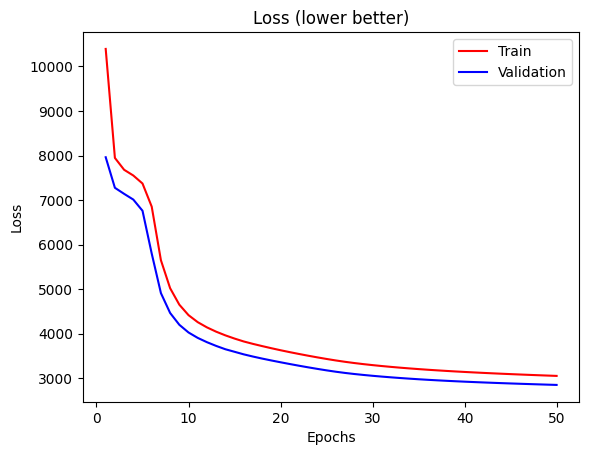

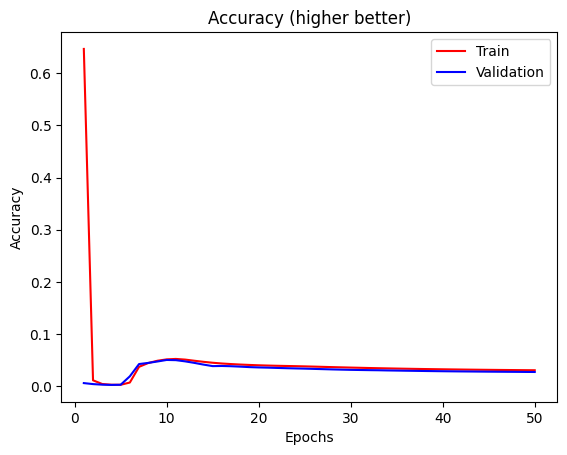

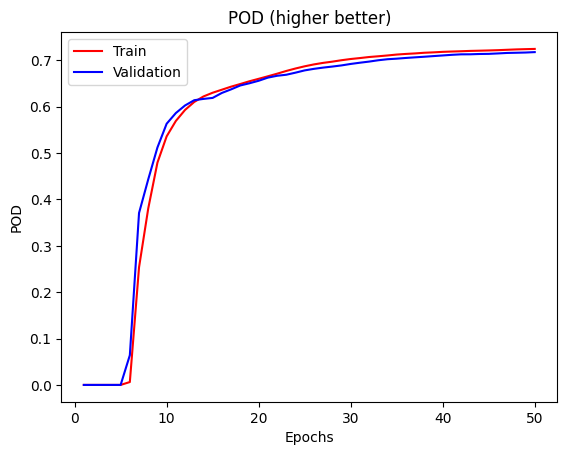

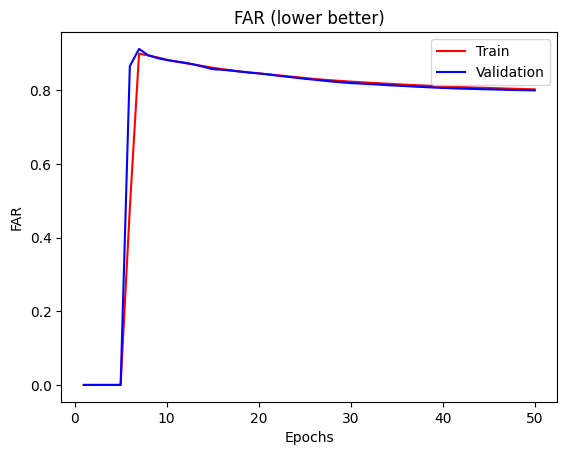

In [14]:
def train(model):
  # random data
  # data = torch.rand((1024,1,50,50), dtype=torch.double)
  # data[data>0.5] = 1.0
  # data[data<0.5] = 0.0

  # GLM data

  data = torch.from_numpy(np.load('flash_count_array.npy')).double()
  data[data>1.0] = 1.0
  print("data has the size : ", data.size())

  train_pct = 0.85
  prev_hours = 6
  next_hours = 6
  batch_size = 32
  start_index_list = list(range(data.size(0) - prev_hours - next_hours))
  random.shuffle(start_index_list)
  train_start_index_list = start_index_list[:int(len(start_index_list)*train_pct)]
  val_start_index_list = start_index_list[int(len(start_index_list)*train_pct):]
  # print("hello")

  # print(len(train_start_index_list))
  # print(len(val_start_index_list))

  ## train set creation
  train_x_set = []
  train_y_set = []
  for i in range(len(train_start_index_list) // batch_size):
    train_x_batch = []
    train_y_batch = []
    for j in range(batch_size):
      start = train_start_index_list[batch_size * i + j]
      train_x_batch.append(data[start:(start+prev_hours),:,:,:])
      train_y_batch.append(data[(start+prev_hours):(start+prev_hours+next_hours),:,:,:])

    train_x_batch = torch.stack(train_x_batch,0)
    train_y_batch = torch.stack(train_y_batch,0)

    train_x_set.append(train_x_batch)
    train_y_set.append(train_y_batch)

  # train_x_set = torch.stack(train_x_set,0)
  # train_y_set = torch.stack(train_y_set,0)
  # print(train_x_set.size())
  # print(train_y_set.size())

  ## validation set creation
  val_x_set = []
  val_y_set = []
  for i in range(len(val_start_index_list) // batch_size):
    val_x_batch = []
    val_y_batch = []
    for j in range(batch_size):
      start = val_start_index_list[batch_size * i + j]
      val_x_batch.append(data[start:(start+prev_hours),:,:,:])
      val_y_batch.append(data[(start+prev_hours):(start+prev_hours+next_hours),:,:,:])

    val_x_batch = torch.stack(val_x_batch,0)
    val_y_batch = torch.stack(val_y_batch,0)

    val_x_set.append(val_x_batch)
    val_y_set.append(val_y_batch)

  # val_x_set = torch.stack(val_x_set,0)
  # val_y_set = torch.stack(val_y_set,0)
  # print(val_x_set.size())
  # print(val_y_set.size())
  # print(data[start:(start+prev_hours+next_hours),:,:,:].size())

  model.double()
  # print(model(train_x_set[0]).size())

  ce_loss = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  epoch = 50

  avg_train_loss_list = []
  avg_val_loss_list = []
  avg_train_POD_list = []
  avg_train_FAR_list = []
  avg_train_ETS_list = []
  train_accuracy_list = []
  avg_val_POD_list = []
  avg_val_FAR_list= []
  avg_val_ETS_list = []
  val_accuracy_list = []

  for e in range(epoch):
    avg_train_loss = 0
    avg_val_loss = 0
    avg_train_POD = 0
    avg_train_FAR = 0
    avg_train_ETS = 0
    train_correct = 0
    avg_val_POD = 0
    avg_val_FAR = 0
    avg_val_ETS = 0
    val_correct = 0

    print("Epoch [",e+1,"/",epoch,"]", end=" ")

    for i in tqdm(range(len(train_x_set))):
      data, target = train_x_set[i].to(torch.device("cuda")), train_y_set[i].to(torch.device("cuda"))
      optimizer.zero_grad()
      # train
      model.train()
      output = model(data)
      # train_loss = ce_loss(output, target)
      train_loss = weighted_cross_entropy_with_logits(output, target, 16)
      train_POD, train_FAR = MeteorologicalMeasures(output, target)
      avg_train_loss = avg_train_loss + train_loss.item()
      avg_train_POD = avg_train_POD + train_POD.item()
      avg_train_FAR = avg_train_FAR + train_FAR.item()
      train_correct += (output.round() == target).double().sum()
      # avg_train_ETS = avg_train_ETS + train_ETS
      train_loss.backward()
      optimizer.step()


    for i in range(len(val_x_set)):
      data, target = val_x_set[i].to(torch.device("cuda")), val_y_set[i].to(torch.device("cuda"))
      # val
      model.eval()
      output = model(data)
      # val_loss = ce_loss(output, target)
      val_loss = weighted_cross_entropy_with_logits(output, target, 16)
      val_POD, val_FAR = MeteorologicalMeasures(output, target)
      avg_val_loss = avg_val_loss + val_loss.item()
      avg_val_POD = avg_val_POD + val_POD.item()
      avg_val_FAR = avg_val_FAR + val_FAR.item()
      val_correct += (output.round() == target).double().sum()
      # avg_val_ETS = avg_val_ETS + val_ETS
      # train_loss.backward()
      # optimizer.step()
    avg_train_loss = avg_train_loss / len(train_x_set)
    avg_train_POD = avg_train_POD / len(train_x_set)
    avg_train_FAR = avg_train_FAR / len(train_x_set)
    avg_train_ETS = avg_train_ETS / len(train_x_set)
    train_accuracy = train_correct.item() / (len(train_x_set)*batch_size*next_hours*50*50)

    avg_train_loss_list.append(avg_train_loss)
    avg_train_POD_list.append(avg_train_POD)
    avg_train_FAR_list.append(avg_train_FAR)
    train_accuracy_list.append(train_accuracy)

    avg_val_loss = avg_val_loss / len(val_x_set)
    avg_val_POD = avg_val_POD / len(val_x_set)
    avg_val_FAR = avg_val_FAR / len(val_x_set)
    avg_val_ETS = avg_val_ETS / len(val_x_set)
    val_accuracy = val_correct.item() / (len(val_x_set)*batch_size*next_hours*50*50)

    avg_val_loss_list.append(avg_val_loss)
    avg_val_POD_list.append(avg_val_POD)
    avg_val_FAR_list.append(avg_val_FAR)
    val_accuracy_list.append(val_accuracy)

    print("train")
    print("loss", avg_train_loss,"|", "acc", train_accuracy,"|", "POD", avg_train_POD,"|", "FAR", avg_train_FAR)#,"|", "train ETS", avg_train_ETS)
    print("validation")
    print("loss", avg_val_loss,"|", "acc", val_accuracy,"|", "POD", avg_val_POD,"|", "FAR", avg_val_FAR)#,"|", "val ETS", avg_val_ETS)
    print()


  print(epoch, len(avg_train_loss_list))
  ## LOSS
  plt.title('Loss (lower better)')
  plt.plot(range(1, epoch+1), avg_train_loss_list, color='red', label='Train')
  plt.plot(range(1, epoch+1), avg_val_loss_list, color='blue', label='Validation')
  # plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  ## ACCURACY
  plt.title('Accuracy (higher better)')
  plt.plot(range(1, epoch+1), train_accuracy_list, color='red', label='Train')
  plt.plot(range(1, epoch+1), val_accuracy_list, color='blue', label='Validation')
  # plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

  ## POD
  plt.title('POD (higher better)')
  plt.plot(range(1, epoch+1), avg_train_POD_list, color='red', label='Train')
  plt.plot(range(1, epoch+1), avg_val_POD_list, color='blue', label='Validation')
  # plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("POD")
  plt.show()

  ## FAR
  plt.title('FAR (lower better)')
  plt.plot(range(1, epoch+1), avg_train_FAR_list, color='red', label='Train')
  plt.plot(range(1, epoch+1), avg_val_FAR_list, color='blue', label='Validation')
  # plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("FAR")
  plt.show()
      # if batch_idx % args.log_interval == 0:
      # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #             epoch, i * len(data), len(train_loader.dataset),
      #             100. * batch_idx / len(train_loader), loss.item()))
      #         if args.dry_run:
      #             break
      # for i in range(opt.steps):
      #     print('STEP: ', i)
      #     def closure():
      #         optimizer.zero_grad()
      #         out = seq(input)
      #         loss = criterion(out, target)
      #         print('loss:', loss.item())
      #         loss.backward()
      #         return loss
      #     optimizer.step(closure)


model = LightNet()
model.to(torch.device('cuda'))
train(model)


In [15]:
# x = torch.rand((32, 6, 1, 50, 50))
# enc = Encoder()
# h,c = enc(x)
# # print(h.size(1)+c.size(1))
# fus = Fusion(h.size(1))
# h,c = fus([h], [c])
# dec = Decoder()
# print("size of x[:,-1,:,:,:]", x[:,-1,:,:,:].size())
# print(h.size())
# out = dec(x[:,-1,:,:,:], h,c)
# print(h.size())
# print(c.size())
# print(torch.cat([h,c], dim=1).size())